In [1]:
import sys; sys.path.append('../../src/playground_jax')
from functools import partial
from time import time

from jax import numpy as jnp, random
from jax import grad, value_and_grad, vmap, jit
from jaxtyping import Array, PyTree
import optax
import matplotlib.pyplot as plt

from models_flax import *

Goal: fit multidimensional scalar function $ f_\alpha: D \subset \mathbb{R}^d \rightarrow \mathbb{R}$

In [2]:
def f(x1, x2, alpha=1.):
    return alpha * (x1**2 + x2**2)
    
#def f(x1, x2, alpha=1.):
#    return  alpha * jnp.sin(jnp.sqrt(x1**2 + x2**2))

1. Generate training data

In [3]:
def generate_data(f, N=101):
    
    # create grid
    x1 = x2 = jnp.linspace(-3, 3, N)
    grid_x1, grid_x2 = jnp.meshgrid(x1, x2, indexing='ij')
    x = jnp.stack((grid_x1, grid_x2))
    x = jnp.moveaxis(x, 0, -1)
    x_flat = jnp.reshape(x, (N*N, 2))
    
    # evaluate on grid
    y = f(grid_x1, grid_x2)
    y_flat = jnp.reshape(y, (N*N, 1))
    
    return x, y, x_flat, y_flat

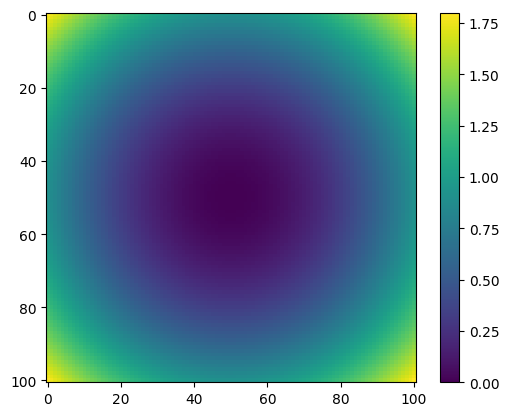

In [4]:
# set a random key
key = random.PRNGKey(1)

f_alpha = partial(f, alpha=1e-1)
N = 101
x, y, x_flat, y_flat = generate_data(f_alpha, N)

fig, ax = plt.subplots()
im = ax.imshow(y)
fig.colorbar(im)

2. Build a model

In [5]:
# define model
d_in, d_out = 2, 1
features = [32, 32] + [d_out]
model = MLP(features, nn.tanh, lambda x: x)

# initialize variables
input = jnp.ones(d_in)
key, split = random.split(key)
params = model.init(key, input)

In [6]:
# evaluate model
batch_size = int(1e3)
input = random.normal(key, (batch_size, d_in), jnp.float32) 
model.apply(params, input).shape

(1000, 1)

3. Choose optimizer 

In [7]:
lr = 1e-3
wd = 1e-5
opt = optax.adamw(learning_rate=lr, weight_decay=wd)
opt_state = opt.init(params)

4. Define loss

In [8]:
def loss_fn(params, x, y):
    pred_y = vmap(model.apply, in_axes=(None, 0))(params, x)
    return jnp.mean((y - pred_y) ** 2)

5. Sample mini-batch function

In [9]:
batch_size = int(1e2)
def get_minibatch(x, key):
    key, subkey = random.split(key)
    idx = random.randint(subkey, (batch_size,), 0, x.shape[0])
    return idx, key

6. Update function

In [10]:
@jit
def update_fn(params, opt_state, x, y, key):

    # sample mini batch
    idx, key = get_minibatch(x, key)    
    
    # compute gradients and loss value
    loss, grads = value_and_grad(loss_fn)(params, x[idx], y[idx])

    # optimizer upate
    updates, opt_state = opt.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return loss, params, opt_state

7. Train

In [11]:
n_iter = int(1e4)
log_period_iter = int(1e3)
for i in range(n_iter):
    t0 = time()
    
    # update
    loss, params, opt_state = update_fn(params, opt_state, x_flat, y_flat, key)

    t1 = time()
    if i % log_period_iter == 0: 
        print('it: {:d}, loss: {:.3e}, time: {:.4f}s'.format(i, loss, t1-t0))

it: 0, loss: 1.998e+00, time: 0.3248s
it: 1000, loss: 4.886e-03, time: 0.0000s
it: 2000, loss: 5.140e-04, time: 0.0000s
it: 3000, loss: 1.403e-04, time: 0.0000s
it: 4000, loss: 5.341e-05, time: 0.0000s
it: 5000, loss: 3.021e-05, time: 0.0000s
it: 6000, loss: 2.065e-05, time: 0.0001s
it: 7000, loss: 1.522e-05, time: 0.0000s
it: 8000, loss: 1.435e-05, time: 0.0000s
it: 9000, loss: 1.490e-05, time: 0.0001s


8. Evaluate

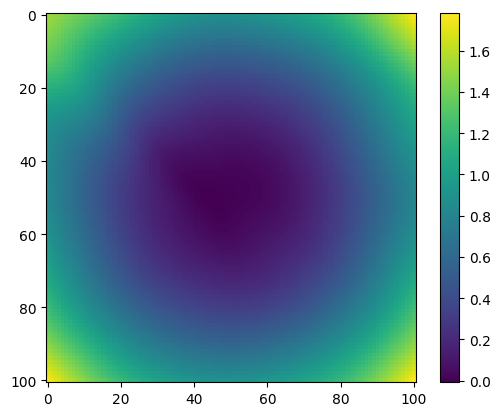

In [12]:
y_pred = vmap(model.apply, in_axes=(None, 0))(params, x_flat).reshape(y.shape)
fig, ax = plt.subplots()
im = ax.imshow(y_pred)
fig.colorbar(im)